In [131]:
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

In [3]:
class continuous_dist(rv_continuous):
    '''
    An attempt to generate a continuous return distribution from discrete pairs of
    payoffs and probabilities.

    Parameters
    ----------
    payoffs : array
        Return scenarios in percentages

    probs : array
        Probababilies for respective payoffs

    model_dist : scipy.stats distribution object, callable, default=scipy.stats.invgauss
        Continuous distribution to model the provided discrete probabilities after.
        Another semi-reasonable choice would be scipy.stats.exponnorm
        
        List available here: https://docs.scipy.org/doc/scipy/reference/stats.html

    '''

    def __init__(self, payoffs=None, probs=None, model_dist=scipy.stats.invgauss, **kwargs):
        super().__init__(**kwargs)
        self.payoffs=payoffs
        self.probs=probs
        self.model_dist = model_dist
        
        # add zero bound for left tail to fit the distribution properly
        # (asset can only go down 100%)
        if payoffs[0] != -1:
            self._payoffs = np.insert(self.payoffs, 0, -1)
            self._probs = self.probs - (0.0001/len(self.probs))
            self._probs = np.insert(self._probs, 0, 0.0001)
        else:
            self._payoffs = self.payoffs
            self._probs = self.probs
            
        with np.warnings.catch_warnings():
            np.warnings.filterwarnings('ignore', 'divide by zero encountered in log')
            np.warnings.filterwarnings('ignore', 'invalid value encountered in log')
            sampled_payoffs = np.random.choice(self._payoffs, size=10000, replace=True, p=self._probs)
            self.dist_params = self.model_dist.fit(sampled_payoffs)
        
    def _pdf(self, x):
        return self.model_dist.pdf(x, *self.dist_params)

    def _rvs(self):
        return self.model_dist.rvs(*self.dist_params, size=self._size)

In [2]:
def shannon_entropy(f, payoffs, probs):
    assert np.round(np.sum(probs), 5) == 1
    assert len(probs) == len(payoffs)
    return -np.sum(probs*np.log(1+f*payoffs))

In [138]:
payoffs = np.array([-0.80, -0.10, 0.15, 0.20])
probs   = np.array([0.05, 0.25, 0.50, 0.20])
# payoffs = np.array([4,   2, -0.6, -0.85])
# probs   = np.array([0.1, 0.1, 0.70,  0.10])
# probs   = np.array([0.25,  0.55,  0.2])
# payoffs = np.array([ 36,  -0.6, -0.85])

bnds = ((0, 1000),)
res = minimize(shannon_entropy, 0.2, args=(payoffs, probs), bounds=bnds, tol=1e-10)
f_star = res.x[0]

print('F_star: {}\nEV:     {:.2f}'.format(f_star, np.dot(payoffs, probs)))

F_star: 0.607248897074963
EV:     0.05


DescribeResult(nobs=1000, minmax=(-0.8, 0.2), mean=0.04924999999999999, variance=0.05271465215215216, skewness=-2.6034122454861865, kurtosis=6.8536644146565155)

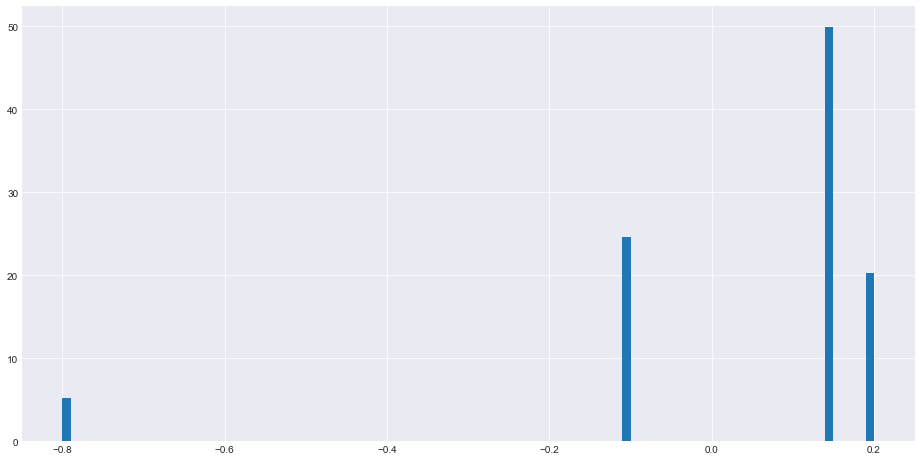

In [146]:
sample_returns = np.random.choice(payoffs, size=1000, replace=True, p=probs)
plt.hist(sample_returns, bins=100, density=True);
scipy.stats.describe(sample_returns)

In [140]:
starting_bankroll = 1000
payouts = []
test_pct_bankrolls = np.linspace(0, 1, 100)

for pct_bankroll in test_pct_bankrolls:
    bankroll = starting_bankroll
    for r in sample_returns:
        bankroll = bankroll*(1+pct_bankroll*r)
    payouts.append(bankroll)
    
bankroll = starting_bankroll
for r in sample_returns:
    bankroll = bankroll*(1+f_star*r)
bankroll

19912886888.267193

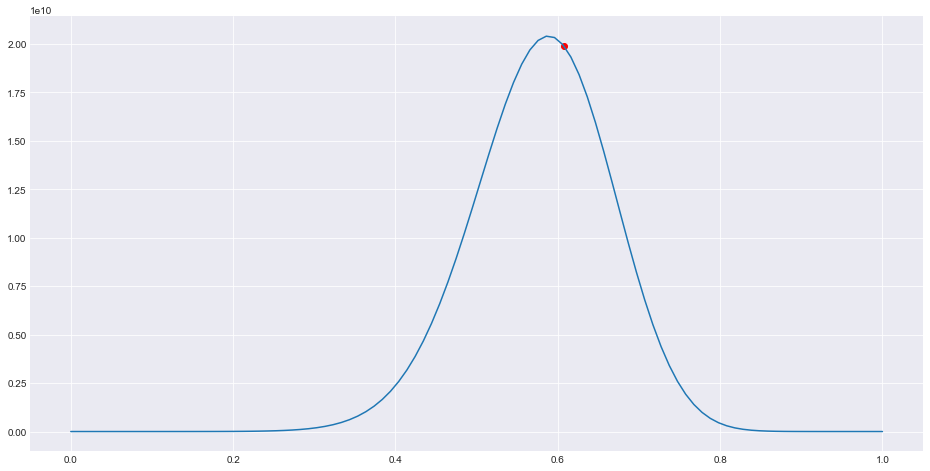

In [141]:
plt.plot(test_pct_bankrolls, payouts)
plt.scatter(f_star, bankroll, color='r');

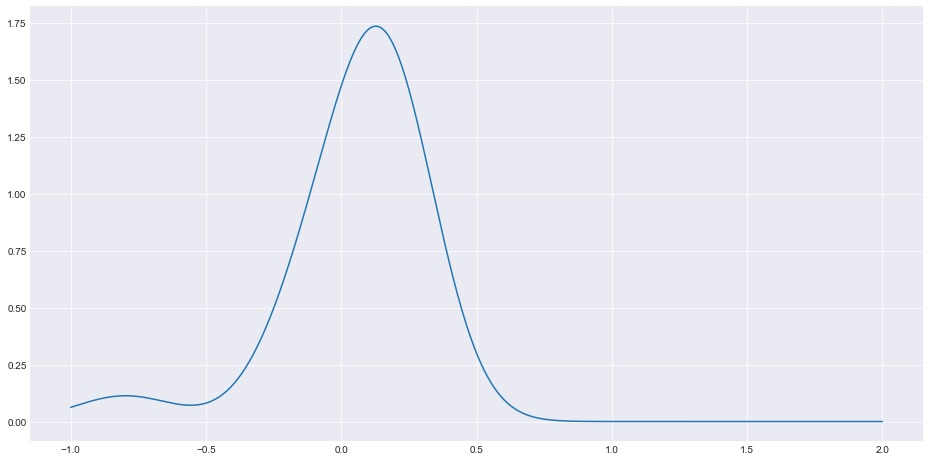

In [142]:
# Gaussian Kernel Density Estimate PDF estimate
datapoints = np.random.choice(payoffs, size=1000, replace=True, p=probs)
kde = scipy.stats.gaussian_kde(datapoints, bw_method=0.8)
x=np.linspace(-1,2,1000)
y = kde.pdf(x)
plt.plot(x,y);

DescribeResult(nobs=10000, minmax=(-0.8336153570700899, 1.1987701134499882), mean=0.04975602562497923, variance=0.07411694591513758, skewness=0.23395610755927382, kurtosis=0.045827103714161765)

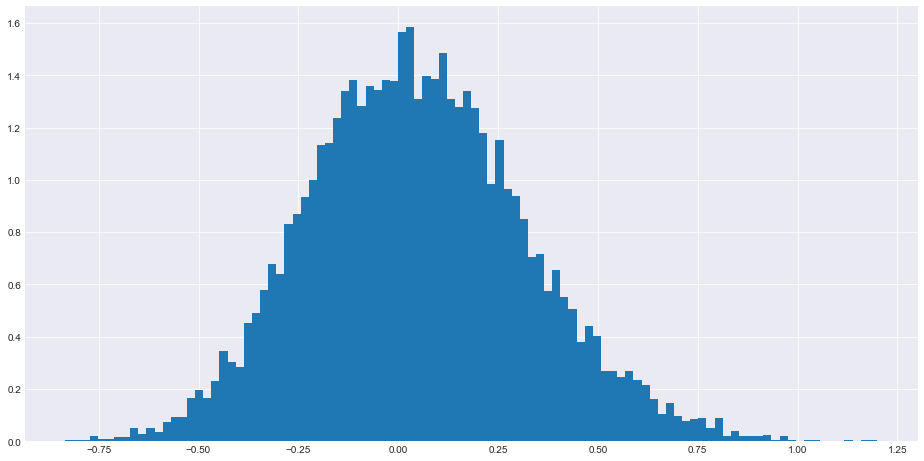

In [144]:
# Sample from a continuous return distribution from discrete pairs of payoffs and probabilities
returns_dist = continuous_dist(payoffs, probs, model_dist=scipy.stats.invgauss)

sample1 = returns_dist.rvs(size=10000)
plt.hist(sample1, bins=100, density=True);
scipy.stats.describe(sample1)

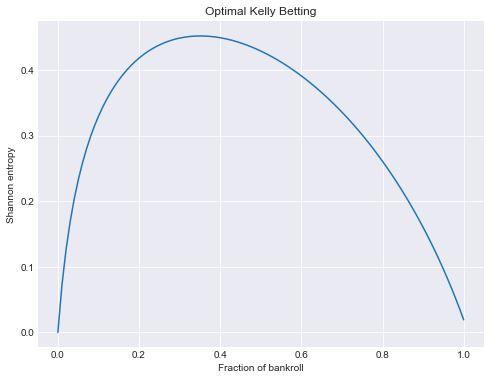

In [5]:
if f_star > 0 and f_star <= 1:
    low = 0
    high = 1+.01
else:
    low = min(0, f_star-1)
    high = f_star+1

x = np.arange(low, high, .01)
y = np.array([-shannon_entropy(e) for e in x])

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title("Optimal Kelly Betting")
plt.xlabel("Fraction of bankroll")
plt.ylabel("Shannon entropy")
plt.show()

In [6]:
# expected value
'${:,.0f}'.format(10000*(1+f_star*ev))

'$39,823'

In [7]:
# max payoff
'${:,.0f}'.format(10000*(1+f_star*mp))

'$136,309'

In [8]:
# downside case
'${:,.0f}'.format(10000*(1+f_star*lp))

'$7,018'